In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Utils

In [2]:
def show_gray(img, title=None, cmap="gray", figsize=(5,5), print_array=False, print_minmax=False, vmin=0, vmax=255):
    if print_array:
        print(img)

    if print_minmax:
        print("min =", int(np.min(img)), "| max =", int(np.max(img)))

    plt.figure(figsize=figsize)
    plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()


def calc_snr_db(img_ref, img_rec, eps=1e-12):
    if img_ref.shape != img_rec.shape:
        raise ValueError("Hai ảnh phải cùng shape.")

    ref = img_ref.astype(np.float64)
    rec = img_rec.astype(np.float64)

    signal = np.sum(ref * ref)
    noise = np.sum((ref - rec) ** 2)

    if noise <= eps:
        snr_db = float("inf")
    else:
        snr_db = 10.0 * np.log10(signal / noise)
    print("SNR (dB) =", snr_db)
    return snr_db


def undetect_misdetect_from_change(img_noisy, img_restored, noisy_mask, *, verbose=True):
    if img_noisy.shape != img_restored.shape:
        raise ValueError(f"shape mismatch: noisy={img_noisy.shape}, restored={img_restored.shape}")
    if noisy_mask.shape != img_noisy.shape:
        raise ValueError(f"mask shape mismatch: mask={noisy_mask.shape}, img={img_noisy.shape}")

    gt_noisy = noisy_mask.astype(bool)
    changed = (img_restored != img_noisy)
    unchanged = ~changed

    total_noisy = int(gt_noisy.sum())
    total_good  = int((~gt_noisy).sum())

    undetected = int((gt_noisy & unchanged).sum())
    misdetected = int(((~gt_noisy) & changed).sum())

    pct_undetection = 0.0 if total_noisy == 0 else (undetected / total_noisy) * 100.0
    pct_misdetection = 0.0 if total_good == 0 else (misdetected / total_good) * 100.0

    if verbose:
        print(f"[Undetection]  undetected={undetected}/{total_noisy}  = {pct_undetection:.4f}%")
        print(f"[Mis-detect]   misdetected={misdetected}/{total_good} = {pct_misdetection:.4f}%")

    return pct_undetection, pct_misdetection


## Add noise

In [3]:
def add_impulse_noise_gray(img, p1=0.3, p2=0.3, delta=0, seed=42):
    if img.ndim != 2:
        raise ValueError("Hàm này chỉ nhận ảnh grayscale (H, W).")
    if p1 < 0 or p2 < 0 or (p1 + p2) > 1:
        raise ValueError("Cần p1>=0, p2>=0 và p1+p2<=1")
    if delta < 0:
        raise ValueError("delta phải >= 0")

    rng = np.random.default_rng(seed)
    out = img.copy()

    # if np.issubdtype(out.dtype, np.integer):
    #     vmin = int(np.iinfo(out.dtype).min)
    #     vmax = int(np.iinfo(out.dtype).max)
    # else:
    #     vmin = float(out.min())
    #     vmax = float(out.max())

    vmin = 0
    vmax = 255

    r = rng.random(out.shape)
    pos_mask = (r < p1)
    neg_mask = (r >= p1) & (r < p1 + p2)
    noisy_mask = pos_mask | neg_mask

    if np.issubdtype(out.dtype, np.integer):
        hi_low = max(vmin, vmax - int(delta))
        lo_high = min(vmax, vmin + int(delta))
        out[pos_mask] = rng.integers(hi_low, vmax + 1, size=pos_mask.sum(), dtype=out.dtype)
        out[neg_mask] = rng.integers(vmin, lo_high + 1, size=neg_mask.sum(), dtype=out.dtype)
    else:
        d = float(delta)
        out[pos_mask] = rng.uniform(max(vmin, vmax - d), vmax, size=pos_mask.sum())
        out[neg_mask] = rng.uniform(vmin, min(vmax, vmin + d), size=neg_mask.sum())

    return out, noisy_mask, pos_mask, neg_mask

## Iterative median filter

In [4]:
def iterative_median_filter(img, ksize=5, n_iter=4):
    if img.ndim != 2:
        raise ValueError("Chỉ nhận ảnh grayscale (H, W).")
    if ksize % 2 == 0 or ksize < 3:
        raise ValueError("ksize phải là số lẻ >= 3.")
    if n_iter < 1:
        raise ValueError("n_iter phải >= 1.")
    if img.dtype != np.uint8:
        img = img.astype(np.uint8, copy=False)

    out = img.copy()
    for _ in range(n_iter):
        out = cv2.medianBlur(out, ksize)
    return out

## PSM filter

In [5]:
def psm_noise_detector(P, WD=7, TD=52, ND=10):
    if P.ndim != 2:
        raise ValueError("P phải là ảnh grayscale (H, W).")
    if P.dtype != np.uint8:
        raise ValueError("PSM detector này đang cài cho uint8 (0..255).")
    if WD % 2 == 0 or WD < 3:
        raise ValueError("WD phải là số lẻ >= 3.")
    if ND < 1:
        raise ValueError("ND phải >= 1.")
    if not (0 <= TD <= 255):
        raise ValueError("TD phải trong [0, 255].")

    x = P.copy()
    f = np.zeros_like(P, dtype=np.uint8)

    for _ in range(ND):
        m = cv2.medianBlur(x, WD)
        diff = cv2.absdiff(x, m)
        new_noise = (diff >= TD) & (f == 0)

        f[new_noise] = 1
        x[new_noise] = m[new_noise]

    return f, x

In [6]:
def median_good(patch_vals, patch_good_mask, fallback_vals=None):
    good = patch_vals[patch_good_mask]
    if good.size > 0:
        return np.median(good)
    if fallback_vals is None:
        return np.median(patch_vals)
    return np.median(fallback_vals)

def psm_noise_reduction(P, f, WF=3, border_mode="edge"):
    if P.ndim != 2 or f.ndim != 2:
        raise ValueError("P và f phải là ảnh grayscale (H, W).")
    if P.shape != f.shape:
        raise ValueError("P và f phải cùng shape.")
    if P.dtype != np.uint8:
        raise ValueError("P nên là uint8.")
    if WF % 2 == 0 or WF < 3:
        raise ValueError("WF phải là số lẻ >= 3.")

    H, W = P.shape
    r = WF // 2
    good = (f == 0)

    if border_mode == "reflect":
        pad_mode = "reflect"
    elif border_mode == "edge":
        pad_mode = "edge"
    else:
        raise ValueError("border_mode chỉ hỗ trợ 'reflect' hoặc 'edge'.")

    Pp = np.pad(P, ((r, r), (r, r)), mode=pad_mode)
    Gp = np.pad(good, ((r, r), (r, r)), mode=pad_mode)

    out = P.copy()

    noisy_coords = np.argwhere(f == 1)
    for i, j in noisy_coords:
        patch = Pp[i:i+WF, j:j+WF]
        gpatch = Gp[i:i+WF, j:j+WF]
        out[i, j] = np.uint8(np.round(median_good(patch, gpatch)))

    return out

In [7]:
def psm_filter(P, WD=7, TD=52, ND=10, WF=3, border_mode="edge"):
    f, _ = psm_noise_detector(P, WD=WD, TD=TD, ND=ND)
    out = psm_noise_reduction(P, f, WF=WF, border_mode=border_mode)
    return out


## Proposed filter

In [8]:
def _median_good_window(y_pad, good_pad, i, j, W, pad):
    r = W // 2
    ii = i + pad
    jj = j + pad
    patch = y_pad[ii-r:ii+r+1, jj-r:jj+r+1]
    mpatch = good_pad[ii-r:ii+r+1, jj-r:jj+r+1]
    cnt = int(mpatch.sum())
    if cnt == 0:
        return None, 0
    med = np.median(patch[mpatch])
    return int(np.round(med)), cnt

def system1_edge_flag_noise_detector(P, WD1=7, WD2=9, TD=30, ND=10,
                                     WE1=5, WE2=7, TE=10, max_iter=100,
                                     border_mode="edge"):
    if P.ndim != 2 or P.dtype != np.uint8:
        raise ValueError("P phải là grayscale uint8.")
    if WD1 % 2 == 0 or WD2 % 2 == 0 or WD1 < 3 or WD2 < 3 or WD1 >= WD2:
        raise ValueError("Cần WD1, WD2 là số lẻ >=3 và WD1 < WD2.")
    if WE1 % 2 == 0 or WE2 % 2 == 0 or WE1 < 3 or WE2 < 3 or WE1 >= WE2:
        raise ValueError("Cần WE1, WE2 là số lẻ >=3 và WE1 < WE2.")

    f_wd1, _ = psm_noise_detector(P, WD=WD1, TD=TD, ND=ND)
    f_wd2, _ = psm_noise_detector(P, WD=WD2, TD=TD, ND=ND)

    pad = WE2 // 2
    if border_mode == "reflect":
        pad_mode = "reflect"
    elif border_mode == "edge":
        pad_mode = "edge"
    else:
        raise ValueError("border_mode chỉ hỗ trợ 'reflect' hoặc 'edge'.")

    y = P.copy()
    f_edge = np.zeros_like(P, dtype=np.uint8)
    g = f_wd2.copy()

    prev_sum = None
    stuck = 0
    for _ in range(max_iter):
        s = int(np.sum(g))
        if s == 0:
            print("thoả mãn sum(g) = 0")
            break

        if prev_sum is not None and s == prev_sum:
            stuck += 1
            if stuck >= 25:
                print("g không thay đổi trong 25 iters")
                break
        else:
            stuck = 0
        prev_sum = s

        y_prev = y.copy()
        good = (g == 0)

        y_pad = np.pad(y_prev, ((pad, pad), (pad, pad)), mode=pad_mode)
        good_pad = np.pad(good, ((pad, pad), (pad, pad)), mode=pad_mode)

        coords = np.argwhere(g == 1)
        # done_mask = np.zeros_like(g, dtype=bool)
        for i, j in coords:
            m1, M1 = _median_good_window(y_pad, good_pad, i, j, WE1, pad)
            m2, M2 = _median_good_window(y_pad, good_pad, i, j, WE2, pad)

            if M1 > 0 and M2 > 0:
                if abs(m1 - m2) >= TE:
                    f_edge[i, j] = 1
                    y[i, j] = np.uint8(m1)
                else:
                    y[i, j] = np.uint8(m2)

            # else: giữ nguyên

        changed = (y != y_prev)
        g[changed] = 0  # y đổi -> g=0, không đổi -> giữ g
        # g[done_mask] = 0

    f_noise = np.where(f_edge == 1, f_wd1, f_wd2).astype(np.uint8)
    show_gray(f_noise, vmin=0, vmax=1)
    return f_noise, f_edge, f_wd1, f_wd2, y, g

In [9]:
def system2_verify(P, f_noise, f_edge, TC=20, TN=10, TR=0.8, dilation_ksize=3):
    if P.ndim != 2 or P.dtype != np.uint8:
        raise ValueError("P phải là grayscale uint8.")
    if f_noise.shape != P.shape or f_edge.shape != P.shape:
        raise ValueError("f_noise, f_edge phải cùng shape với P.")

    f_noise = (f_noise > 0).astype(np.uint8)
    f_edge  = (f_edge  > 0).astype(np.uint8)

    kernel = np.ones((dilation_ksize, dilation_ksize), np.uint8)
    F_edge = cv2.dilate(f_edge, kernel, iterations=1)
    F_edge = (F_edge > 0).astype(np.uint8)

    show_gray(F_edge, vmin=0, vmax=1)

    H, W = P.shape
    G = 255
    halfG = G / 2.0
    max_n_global = (min(H, W) - 1) // 2

    F_noise = f_noise.copy()

    targets = np.argwhere((f_noise == 1) & (F_edge == 1))
    for i, j in targets:
        z0 = int(P[i, j])
        is_salt = (z0 >= halfG)

        for n in range(1, max_n_global + 1):
            r0 = max(0, i - n); r1 = min(H - 1, i + n)
            c0 = max(0, j - n); c1 = min(W - 1, j + n)

            fn = f_noise[r0:r1+1, c0:c1+1]
            fe = F_edge[r0:r1+1, c0:c1+1]
            zz = P[r0:r1+1, c0:c1+1]

            same_type = (zz >= halfG) if is_salt else (zz < halfG)
            mask = (fn == 1) & (fe == 0) & same_type

            M = int(mask.sum())
            if M >= TC:
                vals = zz[mask].astype(np.int16)
                M1 = int((np.abs(vals - z0) <= TN).sum())
                R = M1 / M

                if R < TR:
                    F_noise[i, j] = 0
                # else giữ nguyên = 1
                break

    show_gray(F_noise, vmin=0, vmax=1)
    return F_noise, F_edge

In [10]:
def proposed_filter(P,
                    # System 1
                    WD1=7, WD2=9, TD=30, ND=10,
                    WE1=5, WE2=7, TE=10, max_iter=100,
                    border_mode="edge",
                    # System 2
                    TC=20, TN=10, TR=0.8, dilation_ksize=3,
                    # Reduction
                    WF=3):
    f_noise, f_edge, _, _, _, _ = system1_edge_flag_noise_detector(
        P, WD1=WD1, WD2=WD2, TD=TD, ND=ND,
        WE1=WE1, WE2=WE2, TE=TE, max_iter=max_iter,
        border_mode=border_mode
    )

    F_noise, _ = system2_verify(
        P, f_noise, f_edge,
        TC=TC, TN=TN, TR=TR, dilation_ksize=dilation_ksize
    )

    out = psm_noise_reduction(P, F_noise, WF=WF, border_mode=border_mode)
    return out


## Main execution

In [11]:
cfg = {
    "io": {
        "img_path": "lena_gray_512x512.jpg",
        "resize_hw": (512, 512),
        "resize_inter": cv2.INTER_AREA,
    },
    "noise": {
        "p1": 0.30,     # salt prob
        "p2": 0.30,     # pepper prob
        "delta": 5,
        "seed": 42,
    },
    "baseline_iter_median": {
        "ksize": 5,
        "n_iter": 4,
    },
    "psm": {
        "WD": 7,
        "TD": 52,
        "ND": 10,
        "WF": 3,
        "border_mode": "edge",   # "edge" or "reflect"
    },
    "proposed": {
        # System 1
        "WD1": 7, "WD2": 9, "TD": 25, "ND": 10,
        "WE1": 5, "WE2": 7, "TE": 10, "max_iter": 100,
        "border_mode": "edge",

        # System 2
        "TC": 40, "TN": 5, "TR": 0.5, "dilation_ksize": 7,

        # Reduction
        "WF": 3,
    },
    "viz": {
        "figsize_single": (5, 5),
        "figsize_row": (14, 5),
    }
}

Loaded: lena_gray_512x512.jpg | shape = (512, 512) | dtype = uint8


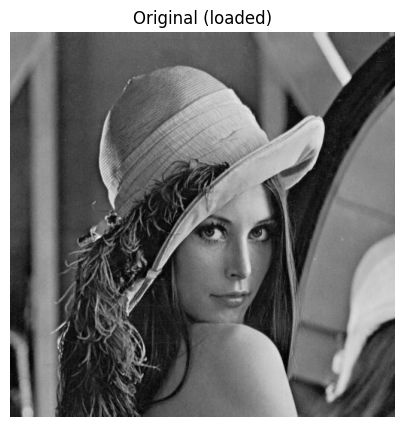

In [12]:
img_path = cfg["io"]["img_path"]
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
if img is None:
    raise FileNotFoundError(f"file not found: {img_path}")

if img.ndim == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

if img.ndim != 2:
    raise ValueError(f"Ảnh sau khi load phải là grayscale 2D, nhưng got shape={img.shape}")

if img.dtype != np.uint8:
    img = img.astype(np.uint8, copy=False)

print("Loaded:", img_path, "| shape =", img.shape, "| dtype =", img.dtype)
show_gray(img, title="Original (loaded)", figsize=cfg["viz"]["figsize_single"])

Resized: | shape = (512, 512) | dtype = uint8


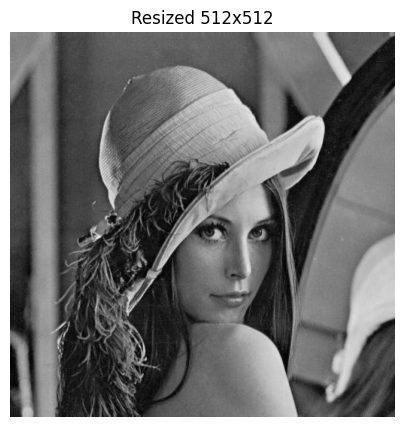

In [20]:
H, W = cfg["io"]["resize_hw"]
img_512 = cv2.resize(img, (W, H), interpolation=cfg["io"]["resize_inter"])
print("Resized:", "| shape =", img_512.shape, "| dtype =", img_512.dtype)
show_gray(img_512, title="Resized 512x512", figsize=cfg["viz"]["figsize_single"])

SNR (dB) = 0.3834039059143537
p salt noise: 0.3
p pepper noise: 0.3


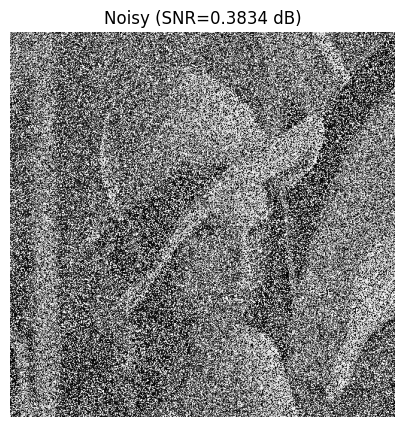

In [17]:
ncfg = cfg["noise"]
img_noisy, noisy_mask, salt_mask, pepper_mask = add_impulse_noise_gray(img_512, p1=ncfg["p1"], p2=ncfg["p2"], delta=ncfg["delta"], seed=ncfg["seed"])
snr_noisy = calc_snr_db(img_512, img_noisy)
print(f"p salt noise: {ncfg['p1']}")
print(f"p pepper noise: {ncfg['p2']}")
show_gray(img_noisy, title=f"Noisy (SNR={snr_noisy:.4f} dB)", figsize=cfg["viz"]["figsize_single"])

In [18]:
print(noisy_mask)

[[False  True False ...  True  True False]
 [ True  True  True ... False False  True]
 [False  True False ... False  True  True]
 ...
 [ True  True False ...  True False False]
 [ True False  True ... False  True  True]
 [ True False  True ...  True False  True]]


SNR (dB) = 18.693124642674267
[Undetection]  undetected=3/157127  = 0.0019%
[Mis-detect]   misdetected=86507/105017 = 82.3743%
SNR (dB) = 14.934234170653403
[Undetection]  undetected=20367/157127  = 12.9621%
[Mis-detect]   misdetected=1977/105017 = 1.8826%
g không thay đổi trong 25 iters


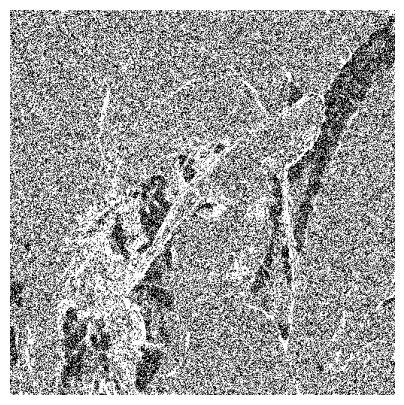

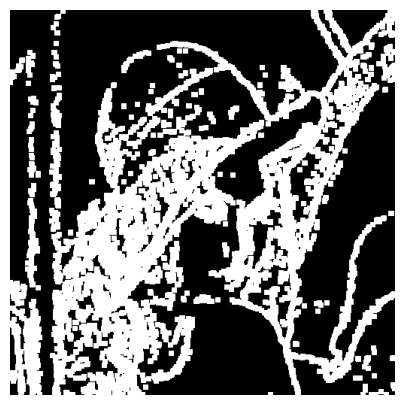

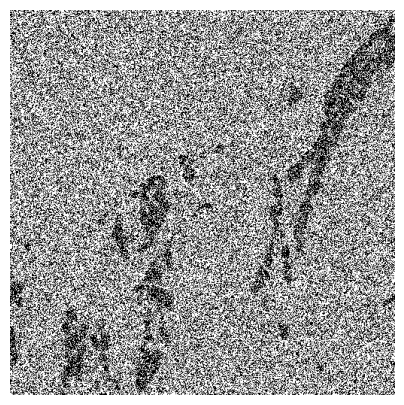

SNR (dB) = 17.157923030380907
[Undetection]  undetected=7619/157127  = 4.8489%
[Mis-detect]   misdetected=416/105017 = 0.3961%


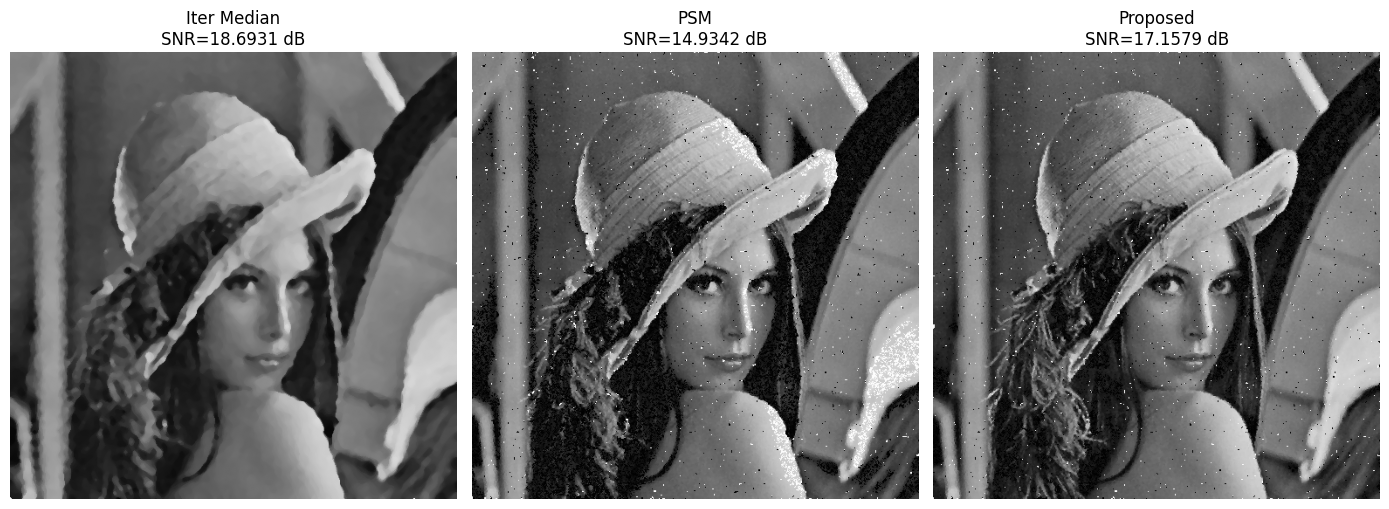

In [19]:
# 4) Apply filters: baseline, PSM, proposed
bcfg = cfg["baseline_iter_median"]
img_med = iterative_median_filter(img_noisy, ksize=bcfg["ksize"], n_iter=bcfg["n_iter"])
snr_med = calc_snr_db(img_512, img_med)
undetect_misdetect_from_change(img_noisy, img_med, noisy_mask)

psmcfg = cfg["psm"]
img_psm = psm_filter(img_noisy, WD=psmcfg["WD"], TD=psmcfg["TD"], ND=psmcfg["ND"],
                    WF=psmcfg["WF"], border_mode=psmcfg["border_mode"])
snr_psm = calc_snr_db(img_512, img_psm)
undetect_misdetect_from_change(img_noisy, img_psm, noisy_mask)

pcfg = cfg["proposed"]
img_prop = proposed_filter(
    img_noisy,
    WD1=pcfg["WD1"], WD2=pcfg["WD2"], TD=pcfg["TD"], ND=pcfg["ND"],
    WE1=pcfg["WE1"], WE2=pcfg["WE2"], TE=pcfg["TE"], max_iter=pcfg["max_iter"],
    border_mode=pcfg["border_mode"],
    TC=pcfg["TC"], TN=pcfg["TN"], TR=pcfg["TR"], dilation_ksize=pcfg["dilation_ksize"],
    WF=pcfg["WF"],
)
snr_prop = calc_snr_db(img_512, img_prop)
undetect_misdetect_from_change(img_noisy, img_prop, noisy_mask)

# 5) Print 3 filtered images + SNR each
plt.figure(figsize=cfg["viz"]["figsize_row"])
plt.subplot(1, 3, 1)
plt.imshow(img_med, cmap="gray", vmin=0, vmax=255); plt.axis("off")
plt.title(f"Iter Median\nSNR={snr_med:.4f} dB")

plt.subplot(1, 3, 2)
plt.imshow(img_psm, cmap="gray", vmin=0, vmax=255); plt.axis("off")
plt.title(f"PSM\nSNR={snr_psm:.4f} dB")

plt.subplot(1, 3, 3)
plt.imshow(img_prop, cmap="gray", vmin=0, vmax=255); plt.axis("off")
plt.title(f"Proposed\nSNR={snr_prop:.4f} dB")

plt.tight_layout()
plt.show()